In [1]:
import re
import pathlib
import pandas as pd
import spacy
from tqdm import tqdm
tqdm.pandas(desc='Progress')
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch
import torch.nn as nn
from torchtext import data
from torchtext import vocab
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')


In [2]:
device=torch.device("cpu")

In [3]:

data_root = pathlib.Path(r'C:\Users\Filip\data')

df = pd.read_csv(data_root/'Sentiment Analysis Dataset.csv', error_bad_lines=False)

print(df.shape)

df['SentimentText'] = df.SentimentText.progress_apply(lambda x: re.sub('\n', ' ', x))


b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


(1578612, 4)


Progress: 100%|██████████████████████████████████████████████████████████| 1578612/1578612 [00:06<00:00, 234173.62it/s]


In [4]:
def split_train_test(df, test_size=0.15):
    train, val = train_test_split(df, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)


In [5]:

nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
def tokenizer(s): return [w.text.lower() for w in nlp(tweet_clean(s))]


def tweet_clean(text):
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    text = re.sub(r'https?:/\/\S+', ' ', text)
    return text.strip()


In [6]:
txt_field = data.Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab=True)
label_field = data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)

train_val_fields = [
    ('ItemID', None),
    ('Sentiment', label_field),
    ('SentimentSource', None),
    ('SentimentText', txt_field)
]


trainds, valds = data.TabularDataset.splits(path=r'C:\Users\Filip\data', format='csv', train='traindf.csv', validation='valdf.csv', fields=train_val_fields, skip_header=True)

vec = vocab.Vectors('glove.6B.100d.txt', r'C:\Users\Filip\data')

txt_field.build_vocab(trainds, valds, max_size=100000, vectors=vec)
label_field.build_vocab(trainds)


traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds),
                                            batch_sizes=(3,3),
                                            sort_key=lambda x: len(x.SentimentText),
                                            device=None,
                                            sort_within_batch=True,
                                            repeat=False)

batch = next(iter(traindl))
type(batch)

torchtext.data.batch.Batch

In [7]:
def idxtosent(batch, idx):
    return ' '.join([txt_field.vocab.itos[i] for i in batch.SentimentText[0][:,idx].data.numpy()])

In [8]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X, y)


In [9]:
train_batch_it = BatchGenerator(traindl, 'SentimentText', 'Sentiment')
next(iter(train_batch_it))


vocab_size = len(txt_field.vocab)
print(vocab_size)
embedding_dim = 100
n_hidden = 64
n_out = 2


100002


In [10]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional

        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        if bidirectional:
            self.out = nn.Linear(self.n_hidden * 2 * 2, self.n_out)
        else:
            self.out = nn.Linear(self.n_hidden * 2, self.n_out)

    def forward(self, seq, lengths):
        bs = seq.size(1)
        self.h = self.init_hidden(bs)
        seq = seq.transpose(0, 1)
        embs = self.emb(seq)
        embs = embs.transpose(0, 1)
        embs = pack_padded_sequence(embs, lengths)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)

        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1, 2, 0), 1).view(bs, -1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1, 2, 0), 1).view(bs, -1)
        outp = self.out(torch.cat([avg_pool, max_pool], dim=1))
        return F.log_softmax(outp)

    def init_hidden(self, batch_size):
        if self.bidirectional:
            return torch.zeros((2, batch_size, self.n_hidden)).to(device)
        else:
            return torch.zeros((1, batch_size, self.n_hidden)).to(device)


def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in range(epochs):
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0

        t = tqdm(iter(train_dl), leave=False, total=num_batch)
        for (X, lengths), y in t:
            y_gpu=y.to(device)
            X_gpu=X.to(device)
            lengths_gpu=lengths.to(device)
            t.set_description(f'Epoch {epoch}')
            lengths = lengths

            opt.zero_grad()
            pred = model(X_gpu, lengths_gpu).to(device)
            loss = loss_fn(pred, y_gpu).to(device)
            loss.backward()
            opt.step()

            t.set_postfix(loss=loss.item())
            pred_idx = torch.max(pred, dim=1)[1]

            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idx.cpu().data.numpy())
            total_loss_train += loss.item()


        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train / len(train_dl)

        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for (X, lengths), y in tqdm(val_dl, leave=False):
                y_gpu = y.to(device)
                X_gpu = X.to(device)
                lengths_gpu = lengths.to(device)
                pred = model(X_gpu, lengths_gpu)
                loss = loss_fn(pred, y_gpu)
                pred_idx = torch.max(pred, 1)[1]
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred_idx.cpu().data.numpy())
                total_loss_val += loss.item()
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = total_loss_val / len(valdl)
            print(
                f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valloss:.4f} val_acc: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f}')


traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds), batch_sizes=(512,1024), sort_key=lambda x: len(x.SentimentText), sort_within_batch=True, repeat=False)
train_batch_it = BatchGenerator(traindl, 'SentimentText', 'Sentiment')
val_batch_it = BatchGenerator(valdl, 'SentimentText', 'Sentiment')

In [11]:
model = GRU(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['SentimentText'].vocab.vectors)
checkpoint = torch.load((r'C:\Users\Filip\Desktop\in\m2.pt'))
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [12]:

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [txt_field.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1).to(device)
    length_tensor = torch.LongTensor(length).to(device)
    pred=model(tensor, length_tensor)
    pred_idx = torch.max(pred, dim=1)[1]
    prediction = torch.sigmoid(pred+1)
    return prediction,pred,pred_idx

In [13]:
item,i,ii=predict_sentiment(model,"father kills mother and 3 children in san diego murder suicide police say")

print(item,i,ii)

item,i,ii=predict_sentiment(model,"prince andrew breaks silence on jeffrey epstein letting royal family down")

print(item,i,ii)

item,i,ii=predict_sentiment(model,"good")

print(item,i,ii)

tensor([[0.5937, 0.5569]], grad_fn=<SigmoidBackward>) tensor([[-0.6207, -0.7712]], grad_fn=<LogSoftmaxBackward>) tensor([0])
tensor([[0.6502, 0.4621]], grad_fn=<SigmoidBackward>) tensor([[-0.3799, -1.1518]], grad_fn=<LogSoftmaxBackward>) tensor([0])
tensor([[0.0375, 0.7282]], grad_fn=<SigmoidBackward>) tensor([[-4.2441, -0.0145]], grad_fn=<LogSoftmaxBackward>) tensor([1])


In [14]:


def clean(path):
    title=[]
    ind=[]
    title2=[]
    f = open(path, "r")
   


    j=0
    for i in f:
        title.append(str(i))
        title2.append(title[j].replace('\n', ''))
       
        title2[j]=tweet_clean(title2[j]).lower()
        j=j+1
    return title2

In [16]:
from torchtext.datasets import text_classification
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
NGRAMS2 = 2
import os
if not os.path.isdir('./.data'):
    os.mkdir('./.data')
train_dataset, test_dataset = text_classification.DATASETS['SogouNews'](
    root='./.data', ngrams=NGRAMS2, vocab=None)
BATCH_SIZE2 = 16

450000lines [06:33, 1143.81lines/s]
450000lines [10:45, 696.93lines/s] 
60000lines [01:24, 708.85lines/s] 


In [17]:
class Category(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)



In [18]:

VOCAB_SIZE2 = len(train_dataset.get_vocab())
EMBED_DIM2 = 32
NUN_CLASS2 = len(train_dataset.get_labels())
model2 = Category(VOCAB_SIZE2, EMBED_DIM2, NUN_CLASS2).to(device)


In [19]:


def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label


In [20]:
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer

SogouNews_label = {
1 : "Sports",
2 : "Finance",
3 : "Entertainment",
4 : "Automobile",
5 : "Technology"}

def predict(text, model, vocab, ngrams):
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([vocab[token]
                            for token in ngrams_iterator(tokenizer(text), ngrams)])
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

In [21]:
checkpoint2 = torch.load((r'C:\Users\Filip\Desktop\in\clas2.pt'))
model2.load_state_dict(checkpoint2)


<All keys matched successfully>

In [23]:

vocab2 = train_dataset.get_vocab()
model2 = model2.to("cpu")
#print("This is a %s news" %SogouNews_label[predict(ex_text_str, model2, vocab2, 2)])


In [24]:
title=[]
comp='amazon'
for q in range (30):
    print(q)
    title.append(clean(f'{comp}/{q}{comp}.txt'))
#print(title)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [25]:
title_art=[]
comp_art='amazonart'
for q in range (30):
    print(q)
    title_art.append(clean(f'{comp_art}/{q}{comp_art}.txt'))
#print(title_art)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [26]:
title_fin=[]
comp_fin='amazonfin'
for q in range (30):
    print(q)
    title_fin.append(clean(f'{comp_fin}/{q}{comp_fin}.txt'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [27]:
import numpy as np


poss,negg,filtr_fin=[],[],[]
for j in range (len(title)): 
    inn=[]
    classification=[]
    for i in range (len(title[j])):
            classification.append(predict(title[j][i], model2, vocab2, 2))
            if classification[i]==2:
                inn.append(i)
    #print(inn)
    pos=0
    neg=0
    sq=0
    for i in range (len(inn)):

        a,b,c=predict_sentiment(model,title[j][inn[i]])
        
        neg=neg+abs(float(b[0][0]))
        pos=pos+abs(float(b[0][1]))
        
        #if float(b[0][0])>float(b[0][1])
        sq=sq+(abs((float(b[0][0])))+(float(b[0][1])))
    print(pos,neg,sq,i)
    poss.append(pos)
    negg.append(neg)
    filtr_fin.append(sq/i)
print(filtr_fin)


9.746065515093505 41.1508329808712 31.404767465777695 25
18.626476211007684 51.30551415402442 32.67903794301674 31
22.24597437866032 52.965671017766 30.719696639105678 38
16.99160694051534 54.843364000320435 37.851757059805095 32
27.709979504346848 55.03546095639467 27.325481452047825 40
22.911756919696927 64.33122703805566 41.41947011835873 40
17.71770125068724 36.34286329895258 18.625162048265338 25
26.83811365813017 44.72055385261774 17.88244019448757 33
22.317106776405126 71.50882405787706 49.19171728147194 43
21.676925304345787 63.790180169045925 42.11325486470014 40
22.21932804491371 47.4845365062356 25.26520846132189 32
9.269094730028883 77.44615375995636 68.17705902992748 33
18.023178029805422 39.06205156445503 21.03887353464961 29
12.24393717199564 49.607237815856934 37.363300643861294 31
19.189211801625788 56.081842705607414 36.892630903981626 33
14.01322692586109 45.56156726926565 31.54834034340456 26
14.495237437076867 77.05188575387001 62.556648316793144 40
17.832967218011

In [28]:
poss,negg,filtr_smieci=[],[],[]

for j in range (len(title)):
    sent,sent2=[],[] 
    inn=[]
    classification=[]
    for i in range (len(title[j])):
            classification.append(predict(title[j][i], model2, vocab2, 2))
            a,b,c=predict_sentiment(model,title[j][i])
            
            sent.append(a[0][0])
    classification2=[]
    index,index2=[],[]
    for i in range (len(title_art[j])):
            #print(i)
            
            classification2.append(predict(title_art[j][i], model2, vocab2, 2))
            aa,b,c=predict_sentiment(model,title_art[j][i])
            sent2.append(aa[0][0])
            
            if classification[i]==classification2[i] :
                    index.append(i)
            if (sent[i]-sent2[i])<0.15 and (sent[i]-sent2[i])>-0.15  :
                index2.append(i)
    #print(len(index2))
    final_ind=list(set(index).intersection(index2))
    #print(final_ind)
    pos=0
    neg=0
    sq=0
    for i in range (len(final_ind)):

        a,b,c=predict_sentiment(model,title[j][final_ind[i]])
        
        neg=neg+abs(float(b[0][0]))
        pos=pos+abs(float(b[0][1]))
        
        #if float(b[0][0])>float(b[0][1])
        sq=sq+(abs((float(b[0][0])))+(float(b[0][1])))
    print(pos,neg,sq,i,j)
    poss.append(pos)
    negg.append(neg)
    filtr_smieci.append(sq/i)
print(filtr_smieci)
   
  



7.7068075286224484 32.89518404006958 25.18837651144713 19 0
7.224241659045219 12.730415013618767 5.506173354573548 8 1
4.913449615240097 15.06997936964035 10.156529754400253 10 2
10.695406110025942 34.781249925494194 24.08584381546825 21 3
21.1126718968153 9.972660914063454 -11.140010982751846 15 4
13.735357256606221 37.17970869317651 23.444351436570287 21 5
7.4520614463835955 21.43650296330452 13.984441516920924 12 6
19.903189938515425 22.405290430411696 2.5021004918962717 20 7
3.552205815911293 18.663928151130676 15.111722335219383 9 8
9.463898487389088 30.467633485794067 21.00373499840498 20 9
17.747970843687654 19.608459658920765 1.8604888152331114 18 10
3.237610572949052 22.81203192472458 19.574421351775527 11 11
10.397455705329776 27.13520772010088 16.737752014771104 18 12
5.114975199103355 14.769785940647125 9.65481074154377 10 13
8.758545860648155 12.946408599615097 4.187862738966942 9 14
5.802279527299106 23.1157024204731 17.313422893173993 13 15
8.493795435875654 24.560916289

In [29]:
poss,negg,wszystko_api=[],[],[]
for j in range (len(title)): 
    pos=0
    neg=0
    sq=0
    for i in range (len(title[j])):

        a,b,c=predict_sentiment(model,title[j][i])
        
        neg=neg+abs(float(b[0][0]))
        pos=pos+abs(float(b[0][1]))
        
        #if float(b[0][0])>float(b[0][1])
        sq=sq+(abs((float(b[0][0])))+(float(b[0][1])))
    print(pos,neg,sq,i)
    poss.append(pos)
    negg.append(neg)
    wszystko_api.append(sq/i)
print(wszystko_api)

41.02741896454245 174.28508280590177 133.25766384135932 99
44.44371659634635 170.47587984520942 126.03216324886307 99
46.42423800844699 161.41061679273844 114.98637878429145 99
55.05734371114522 163.97984948195517 108.92250577080995 99
55.24771979218349 157.8349627032876 102.58724291110411 99
55.53585323598236 169.97509272396564 114.43923948798329 99
57.71315300092101 151.66866025328636 93.95550725236535 99
55.77691200282425 154.8505819980055 99.07366999518126 99
52.372013348154724 171.28998717665672 118.917973828502 99
52.264120371080935 179.9746447983198 127.71052442723885 99
53.38071481697261 165.91760272532701 112.5368879083544 99
38.884003126528114 203.73499371111393 164.85099058458582 99
63.18994597857818 146.63847860693932 83.44853262836114 99
46.529803320765495 155.59422589093447 109.06442257016897 99
40.32389121991582 207.7026705686003 167.37877934868447 99
46.43920829426497 189.3447433244437 142.90553503017873 99
44.204953806474805 169.22721176221967 125.02225795574486 99
47.

In [30]:
poss,negg,fin_api=[],[],[]
for j in range (len(title_fin)): 
    pos=0
    neg=0
    sq=0
    for i in range (len(title_fin[j])):

        a,b,c=predict_sentiment(model,title_fin[j][i])
        
        neg=neg+abs(float(b[0][0]))
        pos=pos+abs(float(b[0][1]))
        
        #if float(b[0][0])>float(b[0][1])
        sq=sq+(abs((float(b[0][0])))+(float(b[0][1])))
    print(pos,neg,sq,i)
    poss.append(pos)
    negg.append(neg)
    if i==0:
        fin_api.append(0)
    else:
        
        fin_api.append(sq/i)
print(fin_api)

35.86005739402026 143.9363076388836 108.07625024486333 78
35.029197653755546 133.83365635573864 98.8044587019831 73
41.04716355726123 90.07763515971601 49.03047160245478 60
38.713297087699175 97.2709682378918 58.55767115019262 64
6.100591726601124 14.031568735837936 7.930977009236813 10
7.2011296562850475 25.496614538133144 18.295484881848097 15
32.469868183135986 96.75497844815254 64.28511026501656 60
28.97039754781872 55.96964248409495 26.999244936276227 38
37.03817026410252 148.2052729204297 111.16710265632719 84
44.06061391485855 104.21894477307796 60.158330858219415 68
25.8787762215361 85.9534532725811 60.074677051045 49
16.806824637576938 26.882551196962595 10.075726559385657 22
7.256709614768624 29.78175586462021 22.525046249851584 17
27.267809606390074 92.51378015615046 65.24597054976039 52
25.70986808743328 99.68422113358974 73.97435304615647 54
32.19455698179081 94.86753933876753 62.67298235697672 59
33.10583630204201 80.49529580771923 47.38945950567722 61
33.23958438169211 7

In [31]:
import matplotlib.pyplot as plt

plt.plot(wszystko_api)
plt.show()
plt.plot(fin_api)
plt.show()
plt.plot(filtr_smieci)
plt.show()
plt.plot(filtr_fin)
plt.show()


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-10-28  1748.060059  1778.699951  1742.500000  1777.079956  1777.079956   
2019-10-29  1774.810059  1777.000000  1755.810059  1762.709961  1762.709961   
2019-10-30  1760.239990  1782.380005  1759.119995  1779.989990  1779.989990   
2019-10-31  1775.989990  1792.000000  1771.479980  1776.660034  1776.660034   
2019-11-01  1788.010010  1797.449951  1785.209961  1791.439941  1791.439941   
2019-11-04  1801.010010  1815.060059  1801.010010  1804.660034  1804.660034   
2019-11-05  1809.160034  1810.250000  1794.000000  1801.709961  1801.709961   
2019-11-06  1801.000000  1802.500000  1788.579956  1795.770020  1795.770020   
2019-11-07  1803.760010  1805.900024  1783.479980  1788.199951  1788.199951   
2019-11-08  1787.890015  1789.880005  1774.040039  1785.880005

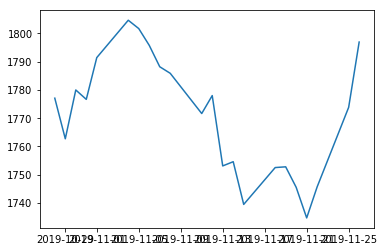

In [32]:
import yfinance as yf
import numpy as np

data = yf.download("AMZN", start="2019-10-27", end="2019-11-27")#GOOG,DIS,NKE,AAPL

print(data)

plt.plot(data[data.columns[3]])
plt.show()


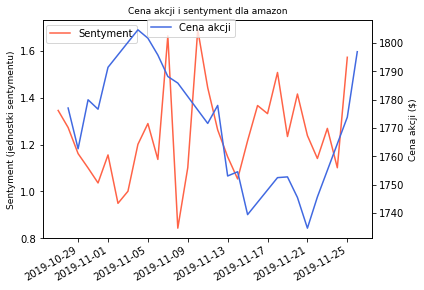

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt

#print(sqq)

now = dt.date(2019,10, 27)
then = now + dt.timedelta(days=30)
days = mdates.drange(now,then,dt.timedelta(days=1))

fig, ax1 = plt.subplots()

color = 'tomato'
ax1.set_ylabel('Sentyment (jednostki sentymentu)', fontsize=9)
ax1.plot(days,wszystko_api,color=color,label="Sentyment")
ax1.tick_params(axis='y')
fig.autofmt_xdate()

ax2 = ax1.twinx() 
color = 'royalblue'
ax2.set_ylabel('Cena akcji ($)', fontsize=9)  
ax2.plot(data[data.columns[4]], color=color,label='Cena akcji')
ax2.tick_params(axis='y')

fig.tight_layout() 
plt.title(f'Cena akcji i sentyment dla {comp}', fontsize=9)

ax2.legend(loc='best', bbox_to_anchor=(0.3,0.9))
ax1.legend(loc='best', bbox_to_anchor=(0.3,1))
#plt.savefig(f'{comp}akcje.png')
#plt.savefig(f'{comp}akcje.eps', format='eps')


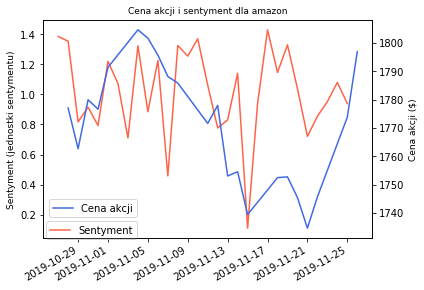

In [35]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt




np.random.seed(1)

now = dt.date(2019,10, 27)
then = now + dt.timedelta(days=30)
days = mdates.drange(now,then,dt.timedelta(days=1))

fig, ax1 = plt.subplots()

color = 'tomato'
ax1.set_ylabel('Sentyment (jednostki sentymentu)', fontsize=9)
ax1.plot(days,fin_api,color=color,label="Sentyment")
ax1.tick_params(axis='y')
fig.autofmt_xdate()

ax2 = ax1.twinx() 

color = 'royalblue'
ax2.set_ylabel('Cena akcji ($)', fontsize=9) 
ax2.plot(data[data.columns[4]], color=color,label='Cena akcji')
ax2.tick_params(axis='y')

fig.tight_layout()
plt.title(f'Cena akcji i sentyment dla {comp}', fontsize=9)

ax2.legend(loc='best', bbox_to_anchor=(0.3,0.2))
ax1.legend(loc='best', bbox_to_anchor=(0.3,0.1))
#plt.savefig(f'{comp}akcje.png')
plt.savefig(f'{comp}akcje.eps', format='eps')


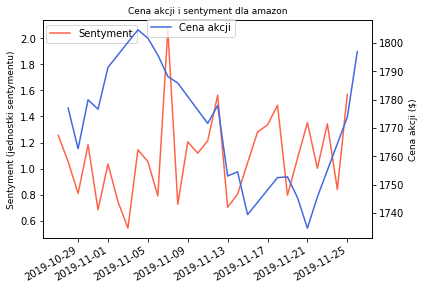

In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt



np.random.seed(1)

now = dt.date(2019,10, 27)
then = now + dt.timedelta(days=30)
days = mdates.drange(now,then,dt.timedelta(days=1))

fig, ax1 = plt.subplots()

color = 'tomato'
ax1.set_ylabel('Sentyment (jednostki sentymentu)', fontsize=9)
ax1.plot(days,filtr_fin,color=color,label="Sentyment")
ax1.tick_params(axis='y')
fig.autofmt_xdate()

ax2 = ax1.twinx() 

color = 'royalblue'
ax2.set_ylabel('Cena akcji ($)', fontsize=9)
ax2.plot(data[data.columns[4]], color=color,label='Cena akcji')
ax2.tick_params(axis='y')

fig.tight_layout() 
plt.title(f'Cena akcji i sentyment dla {comp}', fontsize=9)

ax2.legend(loc='best', bbox_to_anchor=(0.3,0.9))
ax1.legend(loc='best', bbox_to_anchor=(0.3,1))
#plt.savefig(f'{comp}akcje.png')
#plt.savefig(f'{comp}akcje.eps', format='eps')


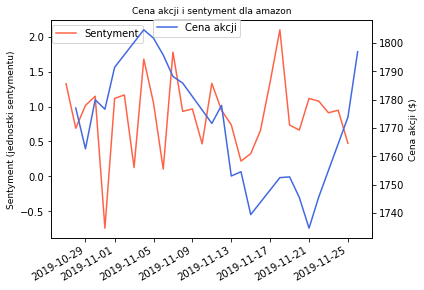

In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt


np.random.seed(1)

now = dt.date(2019,10, 27)
then = now + dt.timedelta(days=30)
days = mdates.drange(now,then,dt.timedelta(days=1))

fig, ax1 = plt.subplots()

color = 'tomato'
ax1.set_ylabel('Sentyment (jednostki sentymentu)', fontsize=9)
ax1.plot(days,filtr_smieci,color=color,label="Sentyment")
ax1.tick_params(axis='y')
fig.autofmt_xdate()


ax2 = ax1.twinx() 

color = 'royalblue'
ax2.set_ylabel('Cena akcji ($)', fontsize=9) 
ax2.plot(data[data.columns[4]], color=color,label='Cena akcji')
ax2.tick_params(axis='y')

fig.tight_layout()
plt.title(f'Cena akcji i sentyment dla {comp}', fontsize=9)

ax2.legend(loc='best', bbox_to_anchor=(0.3,0.9))
ax1.legend(loc='best', bbox_to_anchor=(0.3,1))
#plt.savefig(f'{comp}akcje.png')



In [38]:
sqq2=(wszystko_api - np.min(wszystko_api))/np.ptp(wszystko_api)
index=[0,1,8,9,14,15,21,22]
wsz_api=np.delete(sqq2,index)
stock=((data[data.columns[4]])-np.min(data[data.columns[4]]))/np.ptp(data[data.columns[4]])
st=stock.tolist() 
#print((sqq2),(st))

In [39]:
sqq2=(fin_api - np.min(fin_api))/np.ptp(fin_api)
index=[0,1,8,9,14,15,21,22]
fi_api=np.delete(sqq2,index)
stock=((data[data.columns[4]])-np.min(data[data.columns[4]]))/np.ptp(data[data.columns[4]])
st=stock.tolist() 
#print((sqq2),(st))

In [40]:
sqq2=(filtr_fin - np.min(filtr_fin))/np.ptp(filtr_fin)
index=[0,1,8,9,14,15,21,22]
fil_fin=np.delete(sqq2,index)
stock=((data[data.columns[4]])-np.min(data[data.columns[4]]))/np.ptp(data[data.columns[4]])
st=stock.tolist() 
#print((sqq2),(st))

In [41]:
sqq2=(filtr_smieci - np.min(filtr_smieci))/np.ptp(filtr_smieci)
index=[0,1,8,9,14,15,21,22]
fil_smi=np.delete(sqq2,index)
stock=((data[data.columns[4]])-np.min(data[data.columns[4]]))/np.ptp(data[data.columns[4]])
st=stock.tolist() 
#print((sqq2),(st))

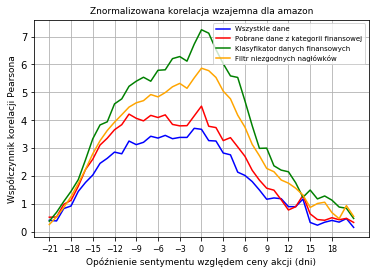

In [42]:
cr1=np.correlate(st,wsz_api,"full")
cr2=np.correlate(st,fi_api,"full")
cr3=np.correlate(st,fil_fin,"full")
cr4=np.correlate(st,fil_smi,"full")
#print(cr)
xx=range(-21,22)
plt.plot(xx,cr3,color="blue",label="Wszystkie dane")
plt.plot(xx,cr1,color="red",label="Pobrane dane z kategorii finansowej")
plt.plot(xx,cr2,color="green",label="Klasyfikator danych finansowych")
plt.plot(xx,cr4,color="orange",label="Filtr niezgodnych nagłówków")
plt.legend(prop={'size': 7})
plt.xlabel('Opóźnienie sentymentu względem ceny akcji (dni)', fontsize=9)
plt.ylabel('Współczynnik korelacji Pearsona', fontsize=9)
plt.xticks(np.arange(min(xx), max(xx), 3.0),fontsize=8)
plt.title(f'Znormalizowana korelacja wzajemna dla {comp}', fontsize=9)
plt.grid()
#plt.savefig(.png')
#plt.savefig(f'{comp}korel.eps', format='eps')